In [2]:
import re
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

## Load Clean Data

In [4]:
# read accepted_processed csv
accepted_processed = pd.read_csv('accepted_processed.csv')

In [5]:
accepted_processed.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term,grade,emp_length,MORTGAGE,OTHER,OWN,RENT,verification_status,car,credit_card,debt_consolidation,housing,major_purchase,medical,other,small_business,vacation,initial_list_status,application_type,disbursement_method,debt_settlement_flag,loan_status,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,earliest_cr_line_year,earliest_cr_line_month
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,0.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,36,2.0,10.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0.0,2019,1,2019,3,2003,8
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,36,2.0,10.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,0.0,2016,6,2019,3,1999,12
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,60,1.0,10.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0.0,2017,6,2019,3,2000,8
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,60,2.0,10.0,1.0,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0.0,2019,2,2019,3,2008,9
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,60,5.0,3.0,1.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,1,0,0.0,2016,7,2018,3,1998,6


In [6]:
# sum of null values 
accepted_processed.isnull().sum().sum()

0

In [7]:
accepted_processed.shape

(1756089, 94)

In [8]:
# sum of null values 
accepted_processed.isnull().sum().sum()

0

In [9]:
accepted_processed.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
int_rate                      float64
installment                   float64
annual_inc                    float64
dti                           float64
delinq_2yrs                   float64
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_amnt               float64
last_fico_ra

## Prepare Data

### Train, Validation, Test Splits

In [10]:
# import Train Test Split
from sklearn.model_selection import train_test_split

# Instantiate X and y
X = accepted_processed.drop('loan_status', axis=1)
y = accepted_processed['loan_status']

# Remainder Test Split
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

# Valudation Train Split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=1)

### Scale the Data

In [11]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# instantiate, fit, transform standard scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)

X_val_ss = ss.transform(X_val)

## Logistic Regression

### Model

In [12]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_ss, y_val)}')

The train accuracy is: 0.8802357564646249
The Validation accuracy is: 0.8790221917167527


In [13]:
# Import PCA, LogisticRegression, and Accuracy Score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# range of n_components
n_components = range(1, 94, 4)

# Create empty list for train and test accuracy and runtime
train_accuracy = []
test_accuracy = []
expl_var = []

# Loop through n_components and fit PCA
for n in n_components:
    
    # print which component is being fit
    print(f'Fitting PCA with {n} components')
    
    # Instantiate and fit PCA
    pca1 = PCA(n_components=n)
    X_train_pca = pca1.fit_transform(X_train_ss)
    X_val_pca = pca1.transform(X_val_ss)
    
    # Instantiate and fit PCA data to Logistic Regression
    log_reg1 = LogisticRegression(max_iter=10000)
    log_reg1.fit(X_train_pca, y_train)
    
    # Explained Variance
    ev = pca1.explained_variance_ratio_.sum()
    
    # Evaluate the model
    train_accuracy.append(log_reg1.score(X_train_pca, y_train))
    test_accuracy.append(log_reg1.score(X_val_pca, y_val))
    expl_var.append(ev)

Fitting PCA with 1 components
Fitting PCA with 5 components
Fitting PCA with 9 components
Fitting PCA with 13 components
Fitting PCA with 17 components
Fitting PCA with 21 components
Fitting PCA with 25 components
Fitting PCA with 29 components
Fitting PCA with 33 components
Fitting PCA with 37 components
Fitting PCA with 41 components
Fitting PCA with 45 components
Fitting PCA with 49 components
Fitting PCA with 53 components
Fitting PCA with 57 components
Fitting PCA with 61 components
Fitting PCA with 65 components
Fitting PCA with 69 components
Fitting PCA with 73 components
Fitting PCA with 77 components
Fitting PCA with 81 components
Fitting PCA with 85 components
Fitting PCA with 89 components
Fitting PCA with 93 components


### Evaluate

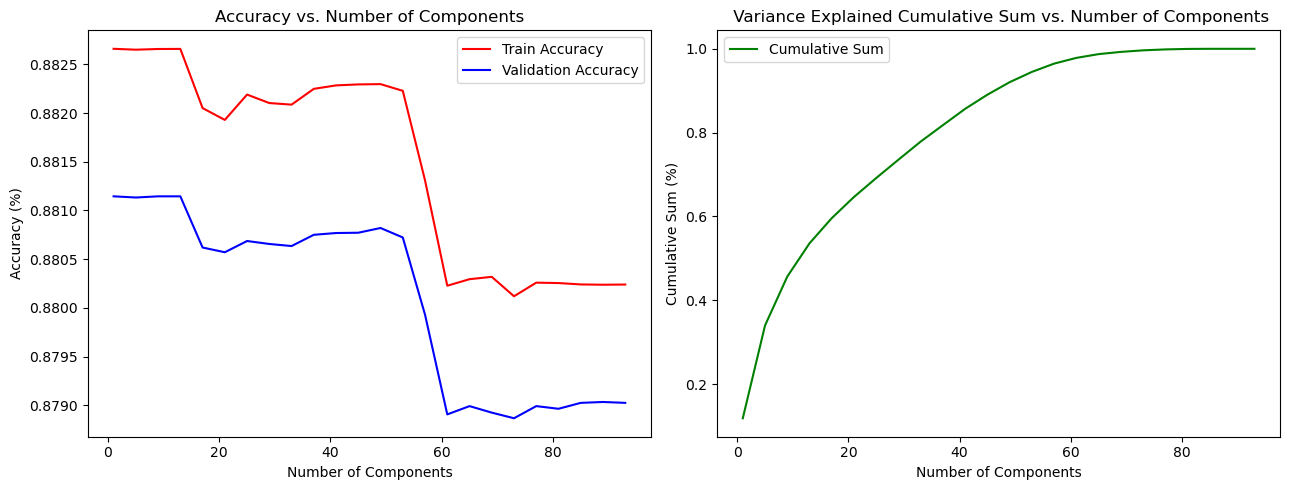

In [14]:
# Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Accuracy vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components, train_accuracy, label='Train Accuracy', color='red')
plt.plot(n_components, test_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (%)')
plt.legend()

# Cumulative Sum vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components, expl_var, label='Cumulative Sum', color='green')
plt.title(' Variance Explained Cumulative Sum vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

In [15]:
# import classification report
from sklearn.metrics import classification_report

# show classification report
print(classification_report(y_val, log_reg.predict(X_val_pca)))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    290132
         1.0       0.15      0.04      0.07     39135

    accuracy                           0.86    329267
   macro avg       0.51      0.50      0.49    329267
weighted avg       0.79      0.86      0.82    329267



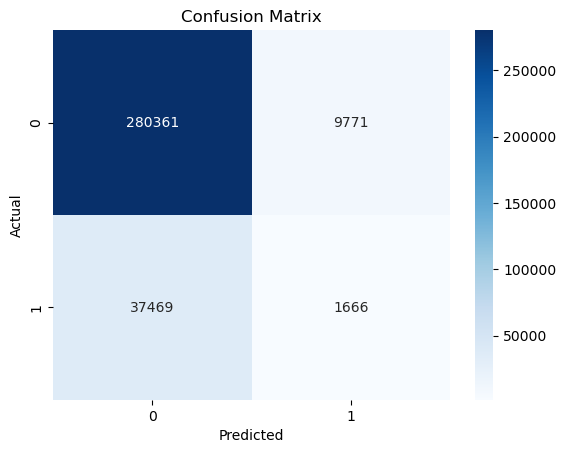

In [16]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# show heatmap confusion matrix
sns.heatmap(confusion_matrix(y_val, log_reg.predict(X_val_pca)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Downsample to 60/40

In [17]:
# distribution of loan status
accepted_processed['loan_status'].value_counts()

0.0    1549364
1.0     206725
Name: loan_status, dtype: int64

In [18]:
# distribution of loan status percentages
accepted_processed['loan_status'].value_counts(normalize=True)

0.0    0.882281
1.0    0.117719
Name: loan_status, dtype: float64

To downsample where 40% of our data is class 1, we can multiply the number of observations in class 1 by 1.5 and get the corresponding amount we need in class 0. 

In [19]:
class1 = 206725
class0 = class1 * 1.5
print(class0)
print(class0 / (class1 + class0))
print(class1 / (class1 + class0))

310087.5
0.6
0.4


In [20]:
# import resample
from sklearn.utils import resample

# sample 60% of class 1 and 100% of class 0
accepted_sample = resample(accepted_processed[accepted_processed['loan_status'] == 0], replace=True, n_samples=310087, random_state=1)

# concatenate class 0 and class 1
accepted_sample = pd.concat([accepted_processed[accepted_processed['loan_status'] == 1], accepted_sample])

# distribution of loan status
print(accepted_sample['loan_status'].value_counts())
print(accepted_sample['loan_status'].value_counts(normalize=True))

0.0    310087
1.0    206725
Name: loan_status, dtype: int64
0.0    0.6
1.0    0.4
Name: loan_status, dtype: float64


In [21]:
accepted_sample.shape

(516812, 94)

## Accepted Sample Data to CSV

In [22]:
# accepted sample to csv
accepted_sample.to_csv('accepted_sample.csv', index=False)

In [23]:
# read accepted_sample csv
accepted_sample = pd.read_csv('accepted_sample.csv')

## Prepare Data

### Train, Validation, Test Splits

In [24]:
# import Train Test Split
from sklearn.model_selection import train_test_split

# Instantiate X and y
X = accepted_sample.drop('loan_status', axis=1)
y = accepted_sample['loan_status']

# Remainder Test Split
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

# Valudation Train Split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=1)

### Scale the Data

In [25]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# instantiate, fit, transform standard scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_val_ss = ss.transform(X_val)

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_ss, y_val)}')

The train accuracy is: 0.6803815538722972
The Validation accuracy is: 0.6802266183709482


In [27]:
# Import PCA, LogisticRegression, and Accuracy Score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# range of n_components
n_components = range(1, 94, 4)

# Create empty list for train and test accuracy and runtime
train_accuracy = []
test_accuracy = []
expl_var = []

# Loop through n_components and fit PCA
for n in n_components:
    
    # print progess 
    print(f'Fitting PCA with {n} components')
    
    # Instantiate and fit PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_ss)
    X_val_pca = pca.transform(X_val_ss)
    
    # Instantiate and fit PCA data to Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(X_train_pca, y_train)
    
    # Explained Variance
    ev = pca.explained_variance_ratio_.sum()
    
    # Evaluate the model
    train_accuracy.append(log_reg.score(X_train_pca, y_train))
    test_accuracy.append(log_reg.score(X_val_pca, y_val))
    expl_var.append(ev)

Fitting PCA with 1 components
Fitting PCA with 5 components
Fitting PCA with 9 components
Fitting PCA with 13 components
Fitting PCA with 17 components
Fitting PCA with 21 components
Fitting PCA with 25 components
Fitting PCA with 29 components
Fitting PCA with 33 components
Fitting PCA with 37 components
Fitting PCA with 41 components
Fitting PCA with 45 components
Fitting PCA with 49 components
Fitting PCA with 53 components
Fitting PCA with 57 components
Fitting PCA with 61 components
Fitting PCA with 65 components
Fitting PCA with 69 components
Fitting PCA with 73 components
Fitting PCA with 77 components
Fitting PCA with 81 components
Fitting PCA with 85 components
Fitting PCA with 89 components
Fitting PCA with 93 components


### Evaluate

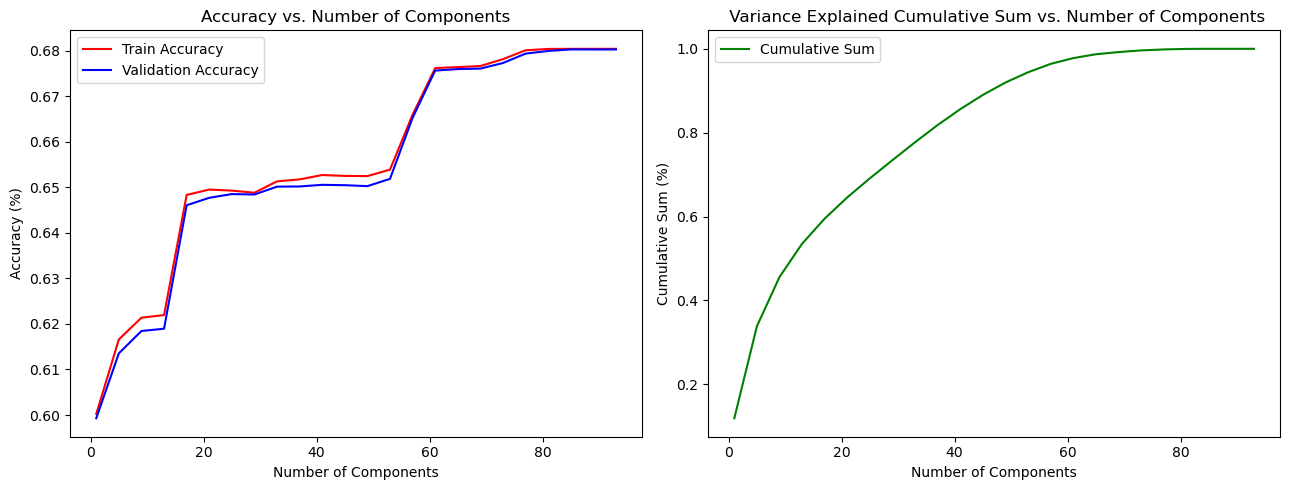

In [28]:
# Create three subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Accuracy vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components, train_accuracy, label='Train Accuracy', color='red')
plt.plot(n_components, test_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (%)')
plt.legend()

# Cumulative Sum vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components, expl_var, label='Cumulative Sum', color='green')
plt.title(' Variance Explained Cumulative Sum vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

In [29]:
# import classification report
from sklearn.metrics import classification_report

# show classification report
print(classification_report(y_val, log_reg.predict(X_val_pca)))

              precision    recall  f1-score   support

         0.0       0.71      0.78      0.75     58075
         1.0       0.62      0.53      0.57     38828

    accuracy                           0.68     96903
   macro avg       0.67      0.66      0.66     96903
weighted avg       0.67      0.68      0.68     96903



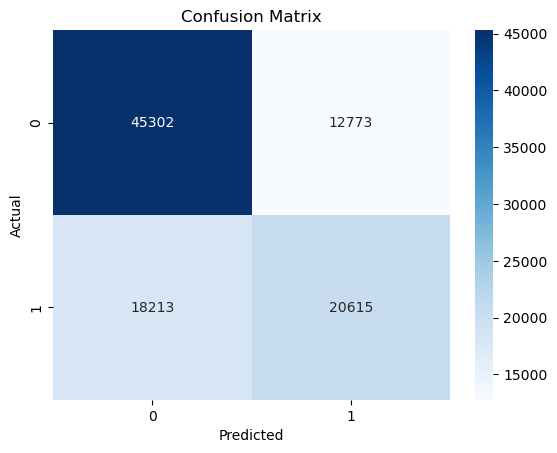

In [30]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# show heatmap confusion matrix
sns.heatmap(confusion_matrix(y_val, log_reg.predict(X_val_pca)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 88% to 68%


Class 1:
- Recall: 4% to 53%
- Precision: 15% to 62%


Class 0:
- Recall: 97% to 78%
- Precision: 88% to 71%

## Random Forest

### Model

In [35]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# Instantiate and fit Random Forest on scaled data
rf = RandomForestClassifier()
rf.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {rf.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {rf.score(X_val_ss, y_val)}')

The train accuracy is: 0.9999965600985188
The Validation accuracy is: 0.7323405880106911


### Evaluate

#### Confusion Matrix

In [36]:
# classification report
print(classification_report(y_val, rf.predict(X_val_ss)))

              precision    recall  f1-score   support

         0.0       0.85      0.67      0.75     58075
         1.0       0.63      0.82      0.71     38828

    accuracy                           0.73     96903
   macro avg       0.74      0.75      0.73     96903
weighted avg       0.76      0.73      0.73     96903



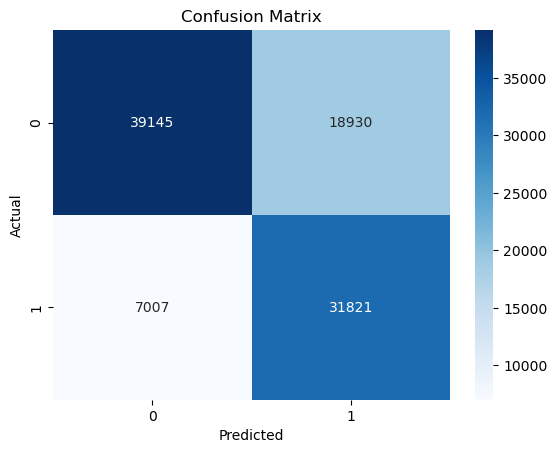

In [37]:
# confusion matrix
sns.heatmap(confusion_matrix(y_val, rf.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Gridsearch Number of Trees and Max Depth

In [44]:
# import grid search and pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])

# parameters
params = {
    'rf__n_estimators': range(32, 128, 4),
    'rf__max_depth': range(3, 9, 2)
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': range(3, 9, 2),
                         'rf__n_estimators': range(32, 128, 4)},
             verbose=4)

[CV 2/5] END rf__max_depth=3, rf__n_estimators=44;, score=0.616 total time=  27.4s
[CV 2/5] END rf__max_depth=3, rf__n_estimators=72;, score=0.652 total time=  45.4s
[CV 5/5] END rf__max_depth=3, rf__n_estimators=100;, score=0.652 total time= 1.0min
[CV 5/5] END rf__max_depth=5, rf__n_estimators=32;, score=0.673 total time=  31.9s
[CV 4/5] END rf__max_depth=5, rf__n_estimators=52;, score=0.679 total time=  50.8s
[CV 5/5] END rf__max_depth=5, rf__n_estimators=80;, score=0.670 total time= 1.3min
[CV 1/5] END rf__max_depth=5, rf__n_estimators=112;, score=0.671 total time= 1.8min
[CV 3/5] END rf__max_depth=7, rf__n_estimators=44;, score=0.682 total time=  56.3s
[CV 4/5] END rf__max_depth=7, rf__n_estimators=68;, score=0.686 total time= 1.5min
[CV 5/5] END rf__max_depth=7, rf__n_estimators=96;, score=0.682 total time= 2.1min
[CV 3/5] END rf__max_depth=3, rf__n_estimators=36;, score=0.652 total time=  23.4s
[CV 4/5] END rf__max_depth=3, rf__n_estimators=64;, score=0.657 total time=  39.8s
[C

In [58]:
# best parameters
grid.best_params_

{'rf__max_depth': 7, 'rf__n_estimators': 40}

### Fit Best Parameters

In [60]:
# Instantiate and fit Random Forest on scaled data
rf = RandomForestClassifier(n_estimators=40, max_depth=7)
rf.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {rf.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {rf.score(X_val_ss, y_val)}')

The train accuracy is: 0.6927583194017324
The Validation accuracy is: 0.6877496052753784


### Evaluate

#### Confusion Matrix

In [61]:
# classification report
print(classification_report(y_val, rf.predict(X_val_ss)))

              precision    recall  f1-score   support

         0.0       0.82      0.62      0.70     58075
         1.0       0.58      0.79      0.67     38828

    accuracy                           0.69     96903
   macro avg       0.70      0.70      0.69     96903
weighted avg       0.72      0.69      0.69     96903



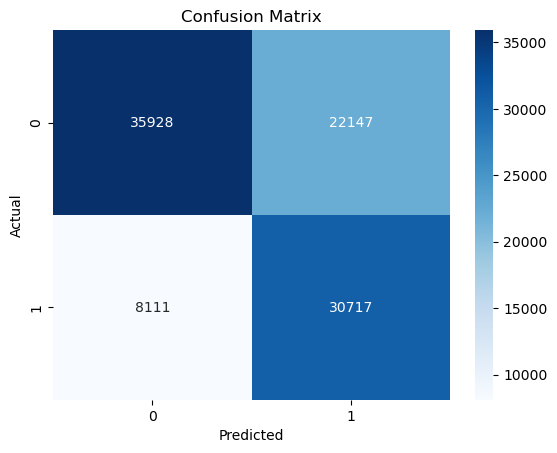

In [62]:
# confusion matrix
sns.heatmap(confusion_matrix(y_val, rf.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XG Boost

### Model

In [50]:
%pip install XGBoost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [63]:
# import xgboost
from xgboost import XGBClassifier

# Instantiate and fit XGBoost on scaled data
xgb = XGBClassifier()
xgb.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {xgb.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {xgb.score(X_val_ss, y_val)}')

The train accuracy is: 0.7664616485383858
The Validation accuracy is: 0.7322683508250518


### Evaluate

#### Confusion Matrix

In [64]:
# classification report
print(classification_report(y_val, xgb.predict(X_val_ss)))

              precision    recall  f1-score   support

         0.0       0.85      0.67      0.75     58075
         1.0       0.63      0.82      0.71     38828

    accuracy                           0.73     96903
   macro avg       0.74      0.75      0.73     96903
weighted avg       0.76      0.73      0.73     96903



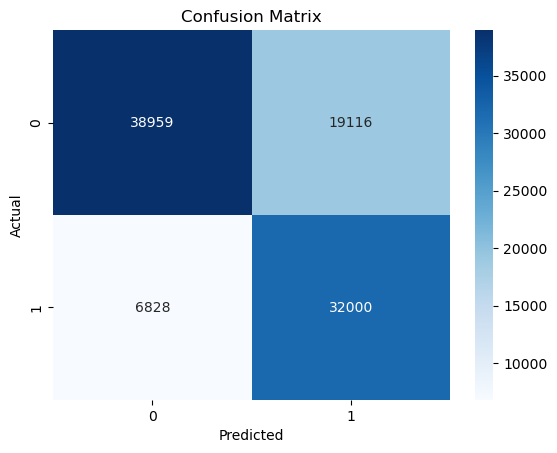

In [65]:
# confusion matrix
sns.heatmap(confusion_matrix(y_val, xgb.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Gridsearch

In [ ]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.05, 0.1, 0.3],
    'xgb__n_estimators': range(50, 300, 50),
    'xgb__gamma':[0, 0.1, 0.2],
    'xgb__subsample': [0.5, 0.7, 0.9],
    'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_rem, y_rem)